In [1]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [2]:
import pandas as pd
ann = pd.read_csv('./PennFudanPed/Annotation/PennFudanVia.csv')
ann

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,../PennFudanPed/PNGImages/FudanPed00001.png,-1,{},2,0,"{""name"":""rect"",""x"":159,""y"":181,""width"":142,""he...","{""type"":""Pedestrian"",""occluded"":{}}"
1,../PennFudanPed/PNGImages/FudanPed00001.png,-1,{},2,1,"{""name"":""rect"",""x"":419,""y"":170,""width"":115,""he...","{""type"":""Pedestrian""}"
2,../PennFudanPed/PNGImages/FudanPed00002.png,-1,{},2,0,"{""name"":""rect"",""x"":67,""y"":92,""width"":123,""heig...","{""type"":""Pedestrian""}"
3,../PennFudanPed/PNGImages/FudanPed00002.png,-1,{},2,1,"{""name"":""rect"",""x"":145,""y"":99,""width"":82,""heig...","{""type"":""Pedestrian"",""occluded"":{""true"":true},..."
4,../PennFudanPed/PNGImages/FudanPed00003.png,-1,{},3,0,"{""name"":""rect"",""x"":304,""y"":134,""width"":142,""he...","{""type"":""Pedestrian""}"
...,...,...,...,...,...,...,...
529,../PennFudanPed/PNGImages/PennPed00094.png,-1,{},2,1,"{""name"":""rect"",""x"":28,""y"":274,""width"":93,""heig...","{""type"":""Pets"",""occluded"":{},""carry-on"":{}}"
530,../PennFudanPed/PNGImages/PennPed00095.png,-1,{},2,0,"{""name"":""rect"",""x"":192,""y"":49,""width"":107,""hei...","{""type"":""Pedestrian"",""carry-on"":{""hand-bag"":tr..."
531,../PennFudanPed/PNGImages/PennPed00095.png,-1,{},2,1,"{""name"":""rect"",""x"":319,""y"":54,""width"":112,""hei...","{""type"":""Pedestrian""}"
532,../PennFudanPed/PNGImages/PennPed00096.png,-1,{},2,0,"{""name"":""rect"",""x"":5,""y"":37,""width"":96,""height...","{""type"":""Pedestrian"",""carry-on"":{""backpack"":tr..."


In [3]:
import json 
json.loads(ann.loc[123, 'region_attributes'])

{'type': 'Pedestrian', 'occluded': {'true': True}, 'carry-on': {}}

Get Images of all non occluded pedestrians

In [4]:
LIST_OF_NON_OCCLUDED_PEDESTRIANS = []
for i in range(len(ann)):
    obj_ = json.loads(ann.loc[i, 'region_attributes'])
    if obj_["type"] == "Pedestrian":
        if ("occluded" not in obj_):
            LIST_OF_NON_OCCLUDED_PEDESTRIANS.append(i)
        elif ("occluded" in obj_ and "true" not in obj_["occluded"]):
            LIST_OF_NON_OCCLUDED_PEDESTRIANS.append(i)

In [5]:
len(LIST_OF_NON_OCCLUDED_PEDESTRIANS)

386

In [6]:
ann.loc[123]["filename"]

'../PennFudanPed/PNGImages/FudanPed00042.png'

In [7]:
def crop_images_and_save(dataframe_, list_of_crop_ids, output_directory, desired_width):
    for i in list_of_crop_ids:
        img_path = os.path.join(dataframe_.loc[i]["filename"][1:]) #[1:] CAUSE IT IS IN THE SAME FOLDER LEVEL
        image = Image.open(img_path)
    
        # Parse the JSON string in the 'region_shape_attributes' column
        region_shape_attributes = json.loads(dataframe_.loc[i, 'region_shape_attributes'])
        
        # Extract coordinates for the bounding box
        x = region_shape_attributes['x']
        y = region_shape_attributes['y']
        width = region_shape_attributes['width']
        height = region_shape_attributes['height']

        if width >= desired_width:
            bbox = (x, y, x + width, y + height)
            cropped_image = image.crop(bbox)
            
            cropped_filename = f"cropped_{i}_{os.path.basename(dataframe_.loc[i]['filename'])}"
            cropped_image.save(os.path.join(output_directory, cropped_filename))

In [8]:
output_dir_of_peds = "non_occluded_peds"

crop_images_and_save(ann, LIST_OF_NON_OCCLUDED_PEDESTRIANS, output_dir_of_peds, 30)

### Resizer

In [9]:
import cv2
import os
import glob

# Step 1: Define the directory containing your images
image_folder = 'non_occluded_peds'

# Step 2: Create the new directory for resized images
resized_folder = f"{image_folder}_resized"
os.makedirs(resized_folder, exist_ok=True)

# Step 3: Loop through your images, resize them, and save them to the new folder
for image_path in glob.glob(os.path.join(image_folder, '*')):
    # Check if file is an image based on its extension
    if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Load the image
        image = cv2.imread(image_path)
        # Resize the image to 64x64 pixels
        resized_image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_LANCZOS4)
        # Create the path for the resized image
        filename = os.path.basename(image_path)
        resized_image_path = os.path.join(resized_folder, filename)
        # Save the resized image
        cv2.imwrite(resized_image_path, resized_image)

print(f"All images have been resized and saved to {resized_folder}")

All images have been resized and saved to non_occluded_peds_resized


In [10]:
from sklearn.feature_extraction.image import extract_patches_2d

image_folder = 'non_occluded_peds_resized/'

all_patches = []

for filename in os.listdir(image_folder):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Load the image
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path)
        image = image.convert('L')  # Convert to grayscale if needed
        image = np.array(image)
        #patches = extract_patches_2d(image, patch_size=(8, 8)) #dl.Patches(image, patch_size=8)
        all_patches.append(image.reshape(-1))

all_patches_matrix = np.vstack(all_patches)
print(all_patches_matrix.shape)

(369, 4096)


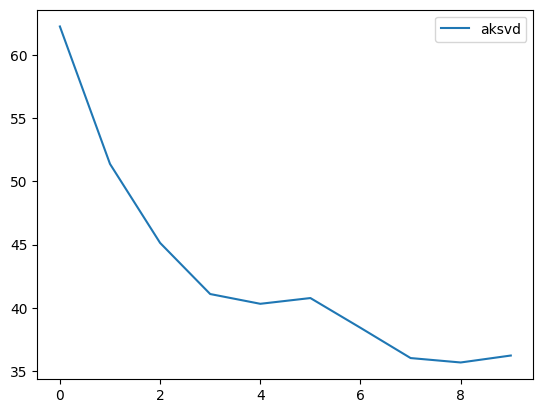

In [11]:
import matplotlib.pyplot as plt

from dictlearn import DictionaryLearning

n_components = 64      # number of atoms
n_features = 64 * 64        # signal dimension
n_nonzero_coefs = 32    # sparsity
n_samples = 369        # number of signals
n_iterations = 20      # number of dictionary learning iterations

max_iter = 10
fit_algorithm = "aksvd"
transform_algorithm = "omp"

dl = DictionaryLearning(
    n_components=n_components,
    max_iter=max_iter,
    fit_algorithm=fit_algorithm,
    transform_algorithm=transform_algorithm,
    n_nonzero_coefs=n_nonzero_coefs,
    code_init=None,
    dict_init=None,
    verbose=False,
    random_state=None,
    kernel_function=None,
    params=None,
    data_sklearn_compat=False
)

dl.fit(all_patches_matrix)

plt.plot(range(max_iter), dl.error_, label=fit_algorithm)
plt.legend()
plt.show()

In [46]:
y = np.load('PennFudanPed/ViaCropsNOC/test_dict.npy')
yl = np.load('PennFudanPed/ViaCropsNOC/test_labels.npy')
y.shape, yl.shape

((334, 128, 64), (334, 9))

In [47]:
yi = cv2.resize(y[0], (64, 64), interpolation = cv2.INTER_LANCZOS4).reshape(1, -1)
yi.shape

(1, 4096)

In [48]:
dl.D_.shape, dl.X_.shape

((369, 64), (64, 4096))

In [49]:
from dictlearn._dictionary_learning import sparse_encode
x, err = sparse_encode(yi.T, dl.X_.T, fit_algorithm, n_nonzero_coefs)
x.shape, err

((64,), 74.0756450239194)

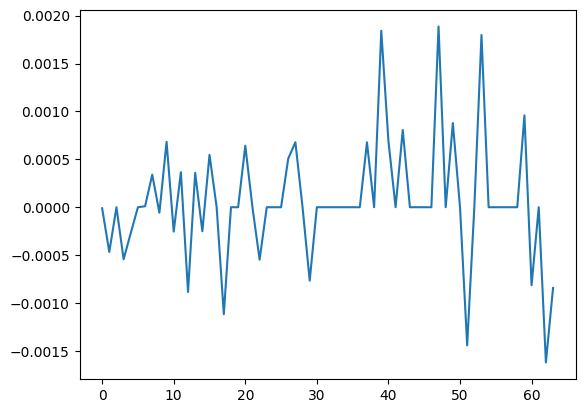

In [50]:
plt.plot(x)

In [51]:
# select some peds
ids_peds = np.random.choice(np.where(yl[:, 1] == 0)[0], 20, replace=False)
ids_peds

array([127,   6, 152,  73, 235,  83, 263,  78,  89, 140, 172, 109,  74,
       311, 154, 283, 312, 280, 175, 173])

In [54]:
yi = []
for i in ids_peds:
    yi.append(cv2.resize(y[i], (64, 64), interpolation = cv2.INTER_LANCZOS4).reshape(1, -1))
yi = np.vstack(yi)
yi.shape

(20, 4096)

In [55]:
x, err = sparse_encode(yi.T, dl.X_.T, fit_algorithm, n_nonzero_coefs)
x.shape, err

((64, 20), 0.6942974383201023)

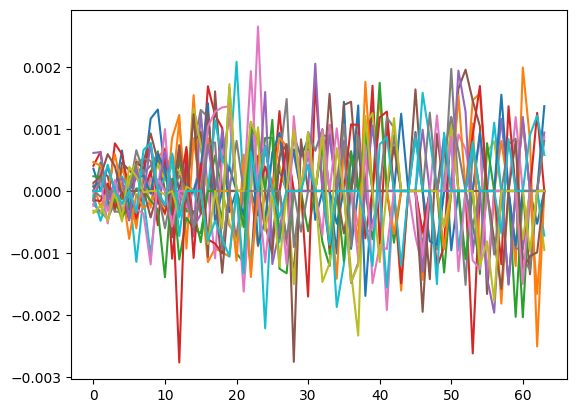

In [56]:
plt.plot(x)

In [57]:
# select some cycs
ids_cycs = np.random.choice(np.where(yl[:, 1] == 1)[0], 20, replace=False)
ids_cycs

array([ 51,  87,  38, 105,  32,  33, 106, 118, 113,  42,  36, 107,  80,
       112, 114,  20, 108,  29,  60,  37])

In [58]:
yi = []
for i in ids_cycs:
    yi.append(cv2.resize(y[i], (64, 64), interpolation = cv2.INTER_LANCZOS4).reshape(1, -1))
yi = np.vstack(yi)
yi.shape

(20, 4096)

In [59]:
x, err = sparse_encode(yi.T, dl.X_.T, fit_algorithm, n_nonzero_coefs)
x.shape, err

((64, 20), 0.728482321759722)

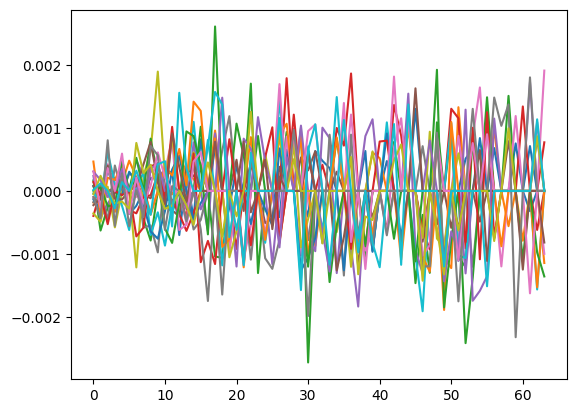

In [60]:
plt.plot(x)